In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.distributions.multivariate_normal import MultivariateNormal
import os
from PIL import Image

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 128
NUM_TRAIN = 50000
NUM_VAL = 10000

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

# train_x = train_x.reshape(-1,784)
# val_x = val_x.reshape(-1,784)
# test_x = test_x.reshape(-1,784)

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dist):
        super(Encoder, self).__init__()
       
        self.normal_dist = MultivariateNormal(torch.zeros(latent_dim),
                                              torch.eye(latent_dim))
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten(),

          # nn.Linear(128 * 4 * 4, hidden_dim),
          # nn.ReLU(inplace=True),
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        if 'bernulli': 
          z = self.reparameterization1(x, mu, log_var)
        if 'gauss':   
          z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.rand_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

    def reparameterization1(self, x, mu, log_var):
    # Get a latent variable sample with the reparameterization trick
        epsilon = self.normal_dist.sample((x.shape[0],)).to(DEVICE)
        z = mu + torch.sqrt(torch.exp(log_var)) * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, num_var, var=0.05):
        super(Decoder, self).__init__()
        self.var = var
        self.num_var = num_var
        self.latent_dim = latent_dim
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(4, 4), stride=(1, 1), padding=(0, 0)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        preds = self.decode(x)
        preds = preds[:, :, 1:29, 1:29]
        return preds

    def sample(self, N, convert_to_numpy=False, suppress_noise=True):
      with torch.no_grad():
          
          z = torch.randn(N, 16, device=DEVICE)
          preds = self.forward(z)
          x = preds
          # the conditional VAE distribution is isotropic Gaussian, hence we just add noise when sampling it
          # for images, one might want to suppress this
          if not suppress_noise:
              x += np.sqrt(self.var) * torch.randn(N, self.num_var, device=DEVICE)   
      if convert_to_numpy:
            z = z.cpu().numpy()
            x = x.cpu().numpy()
            
      return x, z 

            
        
class VAE(nn.Module):
    def __init__(self, encoder, decoder, var=0.5):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.var = var

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_r = self.decoder(z)
        return x_r, mu, log_var

num_channels = train_x.shape[1]
latent_dim = 16
hidden_dim = 128
bernulli_dim = 28 * 28
dist= 'bernulli'
encoder = Encoder(input_dim=num_channels, hidden_dim=hidden_dim, latent_dim=latent_dim, dist = dist).to(DEVICE)
decoder = Decoder(latent_dim=latent_dim, output_dim=num_channels, num_var = train_x.shape[1]).to(DEVICE)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=2048, out_features=16, bias=True)
    (fc_var): Linear(in_features=2048, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

def train_vae(num_epochs, dist= 'bernulli'):
    for epoch in tqdm(range(num_epochs)):
        train_elbos = 0.0
        val_elbos = 0.0
        for batch in train_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            x_recon, mu, log_var = vae(x)

            if dist == 'gauss':
              distances = F.mse_loss(x, x_recon, reduction='none')
              log_p = -0.5 * torch.sum(np.log(vae.var * 2 * np.pi) + distances / vae.var)
              kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
              negative_elbo = -log_p + kl

            if dist == 'bernulli':
              bce = F.binary_cross_entropy(x_recon.reshape(-1, 784), x.view(-1, 784), reduction='sum')
              kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
              negative_elbo = bce + kl
              
            negative_elbo.backward()
            optimizer.step()
            train_elbos += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                x_recon, mu, log_var = vae(x)

                if 'gauss':
                  distances = F.mse_loss(x, x_recon, reduction='none')
                  log_p = -0.5 * torch.sum(np.log(vae.var * 2 * np.pi) + distances / vae.var)
                  kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                  negative_elbo = -log_p + kl

                if 'bernulli':
                  bce = F.binary_cross_entropy(x_recon.reshape(-1, 784), x.view(-1, 784), reduction='sum')
                  kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                  negative_elbo = bce + kl

                val_elbos += negative_elbo.item()
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, train_elbos / NUM_TRAIN, val_elbos / NUM_VAL))
train_vae(num_epochs=20, dist = dist)

  5%|▌         | 1/20 [00:04<01:28,  4.68s/it]

Epoch 1, Mean Training ELBO 290.171586953125, Mean Validation ELBO 210.9207707763672


 10%|█         | 2/20 [00:09<01:23,  4.64s/it]

Epoch 2, Mean Training ELBO 207.8714362109375, Mean Validation ELBO 205.82569030761718


 15%|█▌        | 3/20 [00:13<01:18,  4.62s/it]

Epoch 3, Mean Training ELBO 205.0291333984375, Mean Validation ELBO 201.76219067382812


 20%|██        | 4/20 [00:18<01:13,  4.61s/it]

Epoch 4, Mean Training ELBO 202.0523230078125, Mean Validation ELBO 200.26196135253906


 25%|██▌       | 5/20 [00:22<01:09,  4.61s/it]

Epoch 5, Mean Training ELBO 201.3107291796875, Mean Validation ELBO 198.89734985351564


 30%|███       | 6/20 [00:27<01:04,  4.60s/it]

Epoch 6, Mean Training ELBO 200.64243234375, Mean Validation ELBO 198.5372880126953


 35%|███▌      | 7/20 [00:32<00:59,  4.59s/it]

Epoch 7, Mean Training ELBO 199.86081515625, Mean Validation ELBO 198.4684569580078


 40%|████      | 8/20 [00:36<00:55,  4.60s/it]

Epoch 8, Mean Training ELBO 199.13131587890626, Mean Validation ELBO 197.11782626953126


 45%|████▌     | 9/20 [00:41<00:50,  4.59s/it]

Epoch 9, Mean Training ELBO 197.35255728515625, Mean Validation ELBO 195.70599106445312


 50%|█████     | 10/20 [00:45<00:45,  4.60s/it]

Epoch 10, Mean Training ELBO 194.73485021484376, Mean Validation ELBO 192.22618981933593


 55%|█████▌    | 11/20 [00:50<00:41,  4.60s/it]

Epoch 11, Mean Training ELBO 191.6931339453125, Mean Validation ELBO 190.25481547851564


 60%|██████    | 12/20 [00:55<00:36,  4.61s/it]

Epoch 12, Mean Training ELBO 190.3070347265625, Mean Validation ELBO 189.64439221191407


 65%|██████▌   | 13/20 [00:59<00:32,  4.61s/it]

Epoch 13, Mean Training ELBO 188.81791828125, Mean Validation ELBO 187.84499946289063


 70%|███████   | 14/20 [01:04<00:27,  4.61s/it]

Epoch 14, Mean Training ELBO 187.30936765625, Mean Validation ELBO 185.8932810546875


 75%|███████▌  | 15/20 [01:09<00:23,  4.62s/it]

Epoch 15, Mean Training ELBO 186.32857814453126, Mean Validation ELBO 184.29810556640626


 80%|████████  | 16/20 [01:13<00:18,  4.62s/it]

Epoch 16, Mean Training ELBO 184.1658051171875, Mean Validation ELBO 182.98996325683595


 85%|████████▌ | 17/20 [01:18<00:13,  4.62s/it]

Epoch 17, Mean Training ELBO 182.76593265625, Mean Validation ELBO 180.69324504394532


 90%|█████████ | 18/20 [01:22<00:09,  4.62s/it]

Epoch 18, Mean Training ELBO 180.99680474609374, Mean Validation ELBO 179.13627626953124


 95%|█████████▌| 19/20 [01:27<00:04,  4.63s/it]

Epoch 19, Mean Training ELBO 179.250135390625, Mean Validation ELBO 176.9292671875


100%|██████████| 20/20 [01:32<00:00,  4.61s/it]

Epoch 20, Mean Training ELBO 177.77359056640626, Mean Validation ELBO 175.26509438476563


In [7]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    x_recons = []
    with torch.no_grad():
        x_recon, _, _ = vae(x)
        x_recons.append(x_recon)
    return [x], x_recons
test_batch, test_batch_r = test_vae()

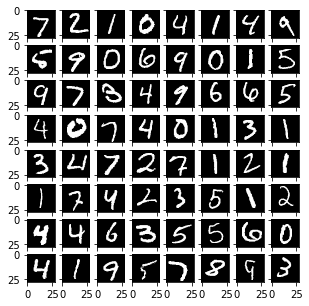

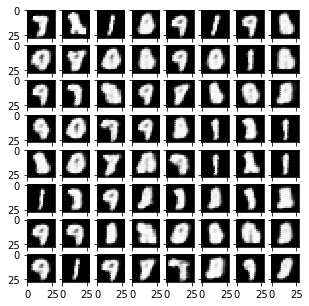

In [8]:
def show_images(x, ncols=64):
    """ plots first ncols images in a batch """
    x = x.view(BATCH_SIZE, 28, 28)
    img_arr = []
    for image in x:
      img_arr.append(image)
    fig = plt.figure(figsize=(5., 5.))
    grid = ImageGrid(fig, 111, 
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

    for ax, im in zip(grid, img_arr):
        
        ax.imshow(im.cpu().numpy(), cmap="Greys_r")
        
show_images(test_batch[0])
show_images(test_batch_r[0])

In [9]:
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

# def train_vae(num_epochs, dist):
#     for epoch in tqdm(range(num_epochs)):
#         train_elbos = 0.0
#         val_elbos = 0.0
#         for batch in train_dataloader:
#             #vae.zero_grad()
#             x, _ = batch
#             x = x.to(DEVICE)
#             x_recon, mu, log_var = vae(x)

#             if 'gauss':
#               distances = F.mse_loss(x, x_recon, reduction='none')
#               log_p = -0.5 * torch.sum(np.log(vae.var * 2 * np.pi) + distances / vae.var)
#               kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#               negative_elbo = -log_p + kl

#             if 'bernulli':
#               bce = F.binary_cross_entropy(x_recon.reshape(-1, 784), x.view(-1, 784), reduction='sum')
#               kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#               negative_elbo = bce + kl
              
#             negative_elbo.backward()
#             optimizer.step()
#             train_elbos += negative_elbo.item()

#         for batch in val_dataloader:
#             x, _ = batch
#             x = x.to(DEVICE)
#             with torch.no_grad():
#                 x_recon, mu, log_var = vae(x)

#                 if 'gauss':
#                   distances = F.mse_loss(x, x_recon, reduction='none')
#                   log_p = -0.5 * torch.sum(np.log(vae.var * 2 * np.pi) + distances / vae.var)
#                   kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#                   negative_elbo = -log_p + kl

#                 if 'bernulli':
#                   bce = F.binary_cross_entropy(x_recon.reshape(-1, 784), x.view(-1, 784), reduction='sum')
#                   kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#                   negative_elbo = bce + kl

#                 val_elbos += negative_elbo.item()
#         if epoch % 5 == 0:
#           with torch.no_grad():
#             # sample from the VAE
#             x, z = decoder.sample(5)
#             zoo = train_x.to(DEVICE)
#             mu_z, var_z, s = encoder(zoo[0:5,:])

#             z_encoded = mu_z + torch.sqrt(var_z) * torch.randn(5, latent_dim, device=DEVICE)

#             # decode the samples
#             x_decoded = decoder(z_encoded)

#             # save images
#             plot_img = np.stack((zoo[0:5, :].detach().cpu().numpy(),
#                                 x_decoded.detach().cpu().numpy(),
#                                 x.detach().cpu().numpy()))
#             plot_img = np.reshape(plot_img, (15, 28, 28))
#             file_name = os.path.join('img_vae', 'samples_{}.png'.format(epoch))
#             save_image_stack(plot_img, 3, 5, file_name, margin = 3)

#         plt.figure(1)
#         plt.clf()
#         plt.plot(ELBO_history)
#         plt.savefig(os.path.join('img_vae', 'elbo.png'))
#         print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, train_elbos / NUM_TRAIN, val_elbos / NUM_VAL))
# train_vae(num_epochs=20, dist = dist)


# class Encoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, latent_dim, dist):
#         super(Encoder, self).__init__()
       
#         self.normal_dist = MultivariateNormal(torch.zeros(latent_dim),
#                                               torch.eye(latent_dim))
#         self.encode = nn.Sequential(
#           nn.Conv2d(input_dim, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
#           nn.ReLU(inplace=True),
#           nn.MaxPool2d(kernel_size=2, stride=2),

#           nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
#           nn.ReLU(inplace=True),
#           nn.MaxPool2d(kernel_size=2, stride=2),

#           nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#           nn.ReLU(inplace=True),
#           nn.MaxPool2d(kernel_size=2, stride=2),

#           nn.Flatten(),

#           # nn.Linear(128 * 4 * 4, hidden_dim),
#           # nn.ReLU(inplace=True),
#         )
#         self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
#         self.fc_var = nn.Linear(128 * 4 * 4, latent_dim)

#     def forward(self, x):
#         encoded = self.encode(x)
#         mu = self.fc_mu(encoded)
#         log_var = self.fc_var(encoded)
#         if 'bernulli': 
#           z = self.reparameterization1(x, mu, log_var)
#         if 'gauss':   
#           z = self.reparameterization(mu, log_var)
#         return z, mu, log_var

#     def reparameterization(self, mu, log_var):
#         std = torch.exp(0.5 * log_var)
#         epsilon = torch.rand_like(std).to(DEVICE)
#         z = mu + std * epsilon
#         return z

#     def reparameterization1(self, x, mu, log_var):
#     # Get a latent variable sample with the reparameterization trick
#         epsilon = self.normal_dist.sample((x.shape[0],)).to(DEVICE)
#         z = mu + torch.sqrt(torch.exp(log_var)) * epsilon
#         return z

# class Decoder(nn.Module):
#     def __init__(self, latent_dim, output_dim, num_var, var=0.05):
#         super(Decoder, self).__init__()
#         self.var = var
#         self.num_var = num_var
#         self.latent_dim = latent_dim
#         self.decode = nn.Sequential(
#             nn.ConvTranspose2d(latent_dim, 128, kernel_size=(4, 4), stride=(1, 1), padding=(0, 0)),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(32, output_dim, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = x.unsqueeze(-1).unsqueeze(-1)
#         preds = self.decode(x)
#         preds = preds[:, :, 1:29, 1:29]
#         return preds

#     def sample(self, N, convert_to_numpy=False, suppress_noise=True):
#       with torch.no_grad():
          
#           z = torch.randn(N, 16, device=DEVICE)
#           preds = self.forward(z)
#           x = preds
          
#           # the conditional VAE distribution is isotropic Gaussian, hence we just add noise when sampling it
#           # for images, one might want to suppress this
#           if not suppress_noise:
#               x += np.sqrt(self.var) * torch.randn(N, self.num_var, device=DEVICE)
              
#       if convert_to_numpy:
#             z = z.cpu().numpy()
#             x = x.cpu().numpy()
            
#       return x, z 

            
        
# class VAE(nn.Module):
#     def __init__(self, encoder, decoder, var=0.5):
#         super(VAE, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.var = var

#     def forward(self, x):
#         z, mu, log_var = self.encoder(x)
#         x_r = self.decoder(z)
#         return x_r, mu, log_var

# num_channels = train_x.shape[1]
# latent_dim = 16
# hidden_dim = 128
# bernulli_dim = 28 * 28
# dist= 'gauss'
# encoder = Encoder(input_dim=num_channels, hidden_dim=hidden_dim, latent_dim=latent_dim, dist = dist).to(DEVICE)
# decoder = Decoder(latent_dim=latent_dim, output_dim=num_channels, num_var = train_x.shape[1]).to(DEVICE)
# vae = VAE(encoder, decoder).to(DEVICE)
# print(vae)

# def save_image_stack(samples, num_rows, num_columns, filename, margin=5, margin_gray_val=1., frame=0, frame_gray_val=0.0):
#     """Save image stack in a tiled image"""

#     # for gray scale, convert to rgb
#     if len(samples.shape) == 3:
#         samples = np.stack((samples,) * 3, -1)

#     height = samples.shape[1]
#     width = samples.shape[2]

#     samples -= samples.min()
#     samples /= samples.max()

#     img = margin_gray_val * np.ones((height*num_rows + (num_rows-1)*margin, width*num_columns + (num_columns-1)*margin, 3))
#     for h in range(num_rows):
#         for w in range(num_columns):
#             img[h*(height+margin):h*(height+margin)+height, w*(width+margin):w*(width+margin)+width, :] = samples[h*num_columns + w, :]

#     framed_img = frame_gray_val * np.ones((img.shape[0] + 2*frame, img.shape[1] + 2*frame, 3))
#     framed_img[frame:(frame+img.shape[0]), frame:(frame+img.shape[1]), :] = img

#     img = Image.fromarray(np.round(framed_img * 255.).astype(np.uint8))

#     img.save(filename)